## Paths

In [1]:
dataset_path = "/home/juliamatos/Área de Trabalho/trabalhoCNN/datasets/SimpleSoyNet"
tensorboard_path = "logs/"
models_path = "./models/SoyNet/"

## Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
# Carrega a ResNet do PyTorch

import torch
from torchvision.models import ResNet, ResNet18_Weights, resnet18


# Transformações para a ResNet18 
my_transform = ResNet18_Weights.DEFAULT.transforms()


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


# Função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [5]:
import torch
from torchvision.datasets import ImageFolder


# Carrega o dataset de imagens com as transformações definidas
data = ImageFolder(root=dataset_path, transform=my_transform)

# Divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

# Cria DataLoaders para treino e teste
batch_size = 512

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

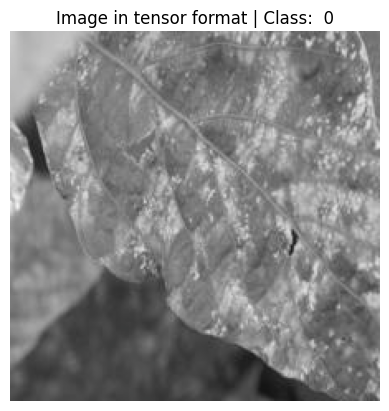

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

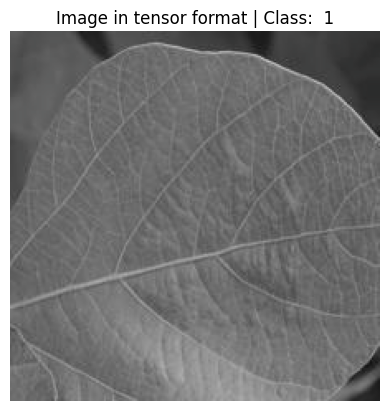

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

## Train

In [8]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

In [9]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy
"""
def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1
"""
def plot_layers(net, writer, epoch):
    # A ResNet18 tem a última camada como 'fc'
    if hasattr(net, "fc"):
        layer = net.fc
        if isinstance(layer, torch.nn.Linear):
            writer.add_histogram('Weight/fc', layer.weight, epoch)
            if layer.bias is not None:
                writer.add_histogram('Bias/fc', layer.bias, epoch)



def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  
    
    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    

        
    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "SoyNet"
        path = f'{models_path}ResNet18-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

## Run with ResNet18

In [10]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [11]:
# Check which layers are frozen
for name, param in model.named_parameters():
    print(f"{name}")

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [12]:
# Congela  os parâmetros da ResNet18, exceto a última camada
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

# Modifica a última camada para o número de classes do dataset
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [13]:
# Check which layers are frozen
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: Frozen
layer2.0.conv2.weight: Frozen
layer2.0.bn2.weight: Frozen
layer2.0.bn2.bias: Frozen
layer2.0.downsample.0.weight: Frozen
layer2.0.downsample.1.weight: Frozen
layer2.0.downsample.1.bias: Frozen
layer2.1.conv1.weight: Frozen
layer2.1.bn1.weight: Frozen
layer2.1.bn1.bias: Frozen
layer2.1.conv2.weight: Frozen
layer2.1.bn2.weight: Frozen
layer2.1.bn2.bias: Frozen
layer3.0.conv1.weight: Frozen
layer3.0.bn1.weight: Frozen
layer3.0.bn1.bias: Frozen
layer3.0.conv2.weight: Frozen
layer3.0.bn2.weight: Frozen
layer3.0.bn2.bias: F

Running on cuda


Training epochs...:   1%|          | 1/120 [00:08<16:22,  8.26s/it]

Saving Best Model with Accuracy:  85.93607305936074
Epoch:   1 | Accuracy : 85.9361%


Training epochs...:   2%|▏         | 2/120 [00:16<16:30,  8.40s/it]

Epoch:   2 | Accuracy : 85.8447%


Training epochs...:   2%|▎         | 3/120 [00:25<16:16,  8.35s/it]

Epoch:   3 | Accuracy : 85.8447%


Training epochs...:   3%|▎         | 4/120 [00:33<15:58,  8.26s/it]

Epoch:   4 | Accuracy : 85.8447%


Training epochs...:   4%|▍         | 5/120 [00:40<15:25,  8.05s/it]

Saving Best Model with Accuracy:  86.16438356164383
Epoch:   5 | Accuracy : 86.1644%


Training epochs...:   5%|▌         | 6/120 [00:48<15:12,  8.00s/it]

Saving Best Model with Accuracy:  86.21004566210046
Epoch:   6 | Accuracy : 86.2100%


Training epochs...:   6%|▌         | 7/120 [00:56<14:51,  7.89s/it]

Saving Best Model with Accuracy:  86.5296803652968
Epoch:   7 | Accuracy : 86.5297%


Training epochs...:   7%|▋         | 8/120 [01:03<14:28,  7.75s/it]

Saving Best Model with Accuracy:  86.94063926940639
Epoch:   8 | Accuracy : 86.9406%


Training epochs...:   8%|▊         | 9/120 [01:11<14:16,  7.72s/it]

Epoch:   9 | Accuracy : 86.9406%


Training epochs...:   8%|▊         | 10/120 [01:19<14:06,  7.70s/it]

Saving Best Model with Accuracy:  87.57990867579909
Epoch:  10 | Accuracy : 87.5799%


Training epochs...:   9%|▉         | 11/120 [01:27<14:08,  7.79s/it]

Saving Best Model with Accuracy:  87.99086757990868
Epoch:  11 | Accuracy : 87.9909%


Training epochs...:  10%|█         | 12/120 [01:35<14:08,  7.86s/it]

Epoch:  12 | Accuracy : 87.9452%


Training epochs...:  11%|█         | 13/120 [01:43<14:18,  8.02s/it]

Saving Best Model with Accuracy:  88.40182648401826
Epoch:  13 | Accuracy : 88.4018%


Training epochs...:  12%|█▏        | 14/120 [01:51<13:59,  7.92s/it]

Saving Best Model with Accuracy:  88.53881278538813
Epoch:  14 | Accuracy : 88.5388%


Training epochs...:  12%|█▎        | 15/120 [01:58<13:39,  7.81s/it]

Saving Best Model with Accuracy:  88.85844748858447
Epoch:  15 | Accuracy : 88.8584%


Training epochs...:  13%|█▎        | 16/120 [02:06<13:34,  7.84s/it]

Saving Best Model with Accuracy:  89.04109589041096
Epoch:  16 | Accuracy : 89.0411%


Training epochs...:  14%|█▍        | 17/120 [02:14<13:22,  7.79s/it]

Saving Best Model with Accuracy:  89.58904109589041
Epoch:  17 | Accuracy : 89.5890%


Training epochs...:  15%|█▌        | 18/120 [02:22<13:13,  7.78s/it]

Saving Best Model with Accuracy:  89.90867579908675
Epoch:  18 | Accuracy : 89.9087%


Training epochs...:  16%|█▌        | 19/120 [02:29<13:03,  7.76s/it]

Saving Best Model with Accuracy:  90.27397260273973
Epoch:  19 | Accuracy : 90.2740%


Training epochs...:  17%|█▋        | 20/120 [02:37<12:57,  7.77s/it]

Saving Best Model with Accuracy:  90.31963470319634
Epoch:  20 | Accuracy : 90.3196%


Training epochs...:  18%|█▊        | 21/120 [02:45<12:56,  7.84s/it]

Saving Best Model with Accuracy:  90.36529680365297
Epoch:  21 | Accuracy : 90.3653%


Training epochs...:  18%|█▊        | 22/120 [02:53<12:44,  7.80s/it]

Epoch:  22 | Accuracy : 90.3653%


Training epochs...:  19%|█▉        | 23/120 [03:01<12:33,  7.77s/it]

Saving Best Model with Accuracy:  90.8675799086758
Epoch:  23 | Accuracy : 90.8676%


Training epochs...:  20%|██        | 24/120 [03:08<12:25,  7.77s/it]

Saving Best Model with Accuracy:  91.23287671232876
Epoch:  24 | Accuracy : 91.2329%


Training epochs...:  21%|██        | 25/120 [03:16<12:16,  7.75s/it]

Saving Best Model with Accuracy:  91.41552511415524
Epoch:  25 | Accuracy : 91.4155%


Training epochs...:  22%|██▏       | 26/120 [03:24<12:06,  7.72s/it]

Epoch:  26 | Accuracy : 91.3699%


Training epochs...:  22%|██▎       | 27/120 [03:32<12:03,  7.78s/it]

Epoch:  27 | Accuracy : 91.3699%


Training epochs...:  23%|██▎       | 28/120 [03:39<11:54,  7.77s/it]

Saving Best Model with Accuracy:  91.82648401826484
Epoch:  28 | Accuracy : 91.8265%


Training epochs...:  24%|██▍       | 29/120 [03:47<11:52,  7.83s/it]

Saving Best Model with Accuracy:  92.00913242009132
Epoch:  29 | Accuracy : 92.0091%


Training epochs...:  25%|██▌       | 30/120 [03:55<11:41,  7.79s/it]

Epoch:  30 | Accuracy : 92.0091%


Training epochs...:  26%|██▌       | 31/120 [04:03<11:42,  7.89s/it]

Saving Best Model with Accuracy:  92.05479452054794
Epoch:  31 | Accuracy : 92.0548%


Training epochs...:  27%|██▋       | 32/120 [04:11<11:29,  7.84s/it]

Epoch:  32 | Accuracy : 92.0548%


Training epochs...:  28%|██▊       | 33/120 [04:19<11:21,  7.83s/it]

Saving Best Model with Accuracy:  92.6027397260274
Epoch:  33 | Accuracy : 92.6027%


Training epochs...:  28%|██▊       | 34/120 [04:26<11:04,  7.73s/it]

Saving Best Model with Accuracy:  93.60730593607306
Epoch:  34 | Accuracy : 93.6073%


Training epochs...:  29%|██▉       | 35/120 [04:34<10:55,  7.72s/it]

Saving Best Model with Accuracy:  93.83561643835617
Epoch:  35 | Accuracy : 93.8356%


Training epochs...:  30%|███       | 36/120 [04:42<10:49,  7.73s/it]

Saving Best Model with Accuracy:  94.15525114155251
Epoch:  36 | Accuracy : 94.1553%


Training epochs...:  31%|███       | 37/120 [04:49<10:28,  7.57s/it]

Epoch:  37 | Accuracy : 94.1553%


Training epochs...:  32%|███▏      | 38/120 [04:56<10:17,  7.53s/it]

Epoch:  38 | Accuracy : 94.1553%


Training epochs...:  32%|███▎      | 39/120 [05:03<09:58,  7.38s/it]

Epoch:  39 | Accuracy : 94.1553%


Training epochs...:  33%|███▎      | 40/120 [05:11<09:59,  7.50s/it]

Epoch:  40 | Accuracy : 94.1553%


Training epochs...:  34%|███▍      | 41/120 [05:19<09:57,  7.57s/it]

Saving Best Model with Accuracy:  94.24657534246575
Epoch:  41 | Accuracy : 94.2466%


Training epochs...:  35%|███▌      | 42/120 [05:27<10:06,  7.77s/it]

Saving Best Model with Accuracy:  94.38356164383562
Epoch:  42 | Accuracy : 94.3836%


Training epochs...:  36%|███▌      | 43/120 [05:35<09:57,  7.76s/it]

Epoch:  43 | Accuracy : 94.3836%


Training epochs...:  37%|███▋      | 44/120 [05:42<09:44,  7.69s/it]

Epoch:  44 | Accuracy : 94.3836%


Training epochs...:  38%|███▊      | 45/120 [05:50<09:39,  7.72s/it]

Saving Best Model with Accuracy:  94.52054794520548
Epoch:  45 | Accuracy : 94.5205%


Training epochs...:  38%|███▊      | 46/120 [05:58<09:28,  7.68s/it]

Epoch:  46 | Accuracy : 94.5205%


Training epochs...:  39%|███▉      | 47/120 [06:05<09:20,  7.67s/it]

Saving Best Model with Accuracy:  94.79452054794521
Epoch:  47 | Accuracy : 94.7945%


Training epochs...:  40%|████      | 48/120 [06:13<09:18,  7.75s/it]

Epoch:  48 | Accuracy : 94.7945%


Training epochs...:  41%|████      | 49/120 [06:21<09:06,  7.70s/it]

Epoch:  49 | Accuracy : 94.7945%


Training epochs...:  42%|████▏     | 50/120 [06:28<08:55,  7.65s/it]

Epoch:  50 | Accuracy : 94.7945%


Training epochs...:  42%|████▎     | 51/120 [06:36<08:54,  7.75s/it]

Epoch:  51 | Accuracy : 94.7945%


Training epochs...:  43%|████▎     | 52/120 [06:44<08:45,  7.73s/it]

Epoch:  52 | Accuracy : 94.7945%


Training epochs...:  44%|████▍     | 53/120 [06:52<08:36,  7.72s/it]

Epoch:  53 | Accuracy : 94.7945%


Training epochs...:  45%|████▌     | 54/120 [06:59<08:28,  7.70s/it]

Epoch:  54 | Accuracy : 94.7945%


Training epochs...:  46%|████▌     | 55/120 [07:07<08:21,  7.72s/it]

Epoch:  55 | Accuracy : 94.7945%


Training epochs...:  47%|████▋     | 56/120 [07:15<08:17,  7.77s/it]

Saving Best Model with Accuracy:  94.93150684931507
Epoch:  56 | Accuracy : 94.9315%


Training epochs...:  48%|████▊     | 57/120 [07:23<08:09,  7.77s/it]

Saving Best Model with Accuracy:  95.20547945205479
Epoch:  57 | Accuracy : 95.2055%


Training epochs...:  48%|████▊     | 58/120 [07:31<08:04,  7.82s/it]

Epoch:  58 | Accuracy : 95.2055%


Training epochs...:  49%|████▉     | 59/120 [07:38<07:53,  7.76s/it]

Epoch:  59 | Accuracy : 95.1598%


Training epochs...:  50%|█████     | 60/120 [07:46<07:45,  7.75s/it]

Epoch:  60 | Accuracy : 95.1598%


Training epochs...:  51%|█████     | 61/120 [07:54<07:37,  7.75s/it]

Epoch:  61 | Accuracy : 95.1598%


Training epochs...:  52%|█████▏    | 62/120 [08:02<07:28,  7.73s/it]

Epoch:  62 | Accuracy : 95.1598%


Training epochs...:  52%|█████▎    | 63/120 [08:10<07:31,  7.92s/it]

Epoch:  63 | Accuracy : 95.1598%


Training epochs...:  53%|█████▎    | 64/120 [08:18<07:27,  7.99s/it]

Epoch:  64 | Accuracy : 95.1598%


Training epochs...:  54%|█████▍    | 65/120 [08:26<07:13,  7.89s/it]

Epoch:  65 | Accuracy : 95.1598%


Training epochs...:  55%|█████▌    | 66/120 [08:33<07:03,  7.84s/it]

Epoch:  66 | Accuracy : 95.1598%


Training epochs...:  56%|█████▌    | 67/120 [08:41<06:52,  7.78s/it]

Epoch:  67 | Accuracy : 95.1598%


Training epochs...:  57%|█████▋    | 68/120 [08:49<06:47,  7.83s/it]

Epoch:  68 | Accuracy : 95.1598%


Training epochs...:  57%|█████▊    | 69/120 [08:57<06:36,  7.77s/it]

Epoch:  69 | Accuracy : 95.1598%


Training epochs...:  58%|█████▊    | 70/120 [09:05<06:31,  7.83s/it]

Epoch:  70 | Accuracy : 95.1598%


Training epochs...:  59%|█████▉    | 71/120 [09:12<06:21,  7.79s/it]

Saving Best Model with Accuracy:  95.34246575342466
Epoch:  71 | Accuracy : 95.3425%


Training epochs...:  60%|██████    | 72/120 [09:20<06:11,  7.74s/it]

Epoch:  72 | Accuracy : 95.1598%


Training epochs...:  61%|██████    | 73/120 [09:28<06:04,  7.75s/it]

Epoch:  73 | Accuracy : 95.3425%


Training epochs...:  62%|██████▏   | 74/120 [09:36<05:58,  7.79s/it]

Epoch:  74 | Accuracy : 95.3425%


Training epochs...:  62%|██████▎   | 75/120 [09:43<05:47,  7.71s/it]

Epoch:  75 | Accuracy : 95.3425%


Training epochs...:  63%|██████▎   | 76/120 [09:51<05:40,  7.73s/it]

Epoch:  76 | Accuracy : 95.2968%


Training epochs...:  64%|██████▍   | 77/120 [09:59<05:32,  7.74s/it]

Epoch:  77 | Accuracy : 95.2968%


Training epochs...:  65%|██████▌   | 78/120 [10:06<05:22,  7.69s/it]

Epoch:  78 | Accuracy : 95.2968%


Training epochs...:  66%|██████▌   | 79/120 [10:14<05:13,  7.66s/it]

Epoch:  79 | Accuracy : 95.2968%


Training epochs...:  67%|██████▋   | 80/120 [10:22<05:08,  7.72s/it]

Saving Best Model with Accuracy:  95.47945205479452
Epoch:  80 | Accuracy : 95.4795%


Training epochs...:  68%|██████▊   | 81/120 [10:29<04:59,  7.68s/it]

Saving Best Model with Accuracy:  95.52511415525115
Epoch:  81 | Accuracy : 95.5251%


Training epochs...:  68%|██████▊   | 82/120 [10:37<04:49,  7.62s/it]

Epoch:  82 | Accuracy : 95.4795%


Training epochs...:  69%|██████▉   | 83/120 [10:44<04:42,  7.65s/it]

Epoch:  83 | Accuracy : 95.5251%


Training epochs...:  70%|███████   | 84/120 [10:52<04:35,  7.64s/it]

Epoch:  84 | Accuracy : 95.4795%


Training epochs...:  71%|███████   | 85/120 [11:00<04:27,  7.64s/it]

Epoch:  85 | Accuracy : 95.4795%


Training epochs...:  72%|███████▏  | 86/120 [11:07<04:19,  7.63s/it]

Saving Best Model with Accuracy:  95.84474885844749
Epoch:  86 | Accuracy : 95.8447%


Training epochs...:  72%|███████▎  | 87/120 [11:15<04:10,  7.58s/it]

Epoch:  87 | Accuracy : 95.8447%


Training epochs...:  73%|███████▎  | 88/120 [11:22<04:01,  7.54s/it]

Epoch:  88 | Accuracy : 95.8447%


Training epochs...:  74%|███████▍  | 89/120 [11:30<03:55,  7.58s/it]

Epoch:  89 | Accuracy : 95.8447%


Training epochs...:  75%|███████▌  | 90/120 [11:38<03:50,  7.69s/it]

Epoch:  90 | Accuracy : 95.8447%


Training epochs...:  76%|███████▌  | 91/120 [11:45<03:42,  7.66s/it]

Epoch:  91 | Accuracy : 95.8447%


Training epochs...:  77%|███████▋  | 92/120 [11:53<03:34,  7.65s/it]

Epoch:  92 | Accuracy : 95.8447%


Training epochs...:  78%|███████▊  | 93/120 [12:01<03:26,  7.66s/it]

Epoch:  93 | Accuracy : 95.8447%


Training epochs...:  78%|███████▊  | 94/120 [12:08<03:18,  7.64s/it]

Epoch:  94 | Accuracy : 95.8447%


Training epochs...:  79%|███████▉  | 95/120 [12:16<03:12,  7.71s/it]

Epoch:  95 | Accuracy : 95.8447%


Training epochs...:  80%|████████  | 96/120 [12:24<03:04,  7.70s/it]

Saving Best Model with Accuracy:  96.0730593607306
Epoch:  96 | Accuracy : 96.0731%


Training epochs...:  81%|████████  | 97/120 [12:32<02:58,  7.75s/it]

Epoch:  97 | Accuracy : 96.0731%


Training epochs...:  82%|████████▏ | 98/120 [12:40<02:53,  7.89s/it]

Epoch:  98 | Accuracy : 96.0731%


Training epochs...:  82%|████████▎ | 99/120 [12:48<02:43,  7.79s/it]

Epoch:  99 | Accuracy : 96.0731%


Training epochs...:  83%|████████▎ | 100/120 [12:55<02:35,  7.76s/it]

Epoch: 100 | Accuracy : 96.0731%


Training epochs...:  84%|████████▍ | 101/120 [13:03<02:25,  7.68s/it]

Epoch: 101 | Accuracy : 96.0731%


Training epochs...:  85%|████████▌ | 102/120 [13:11<02:21,  7.86s/it]

Epoch: 102 | Accuracy : 96.0731%


Training epochs...:  86%|████████▌ | 103/120 [13:18<02:11,  7.74s/it]

Epoch: 103 | Accuracy : 96.0731%


Training epochs...:  87%|████████▋ | 104/120 [13:26<02:05,  7.82s/it]

Epoch: 104 | Accuracy : 96.0731%


Training epochs...:  88%|████████▊ | 105/120 [13:34<01:57,  7.83s/it]

Epoch: 105 | Accuracy : 96.0731%


Training epochs...:  88%|████████▊ | 106/120 [13:42<01:50,  7.90s/it]

Epoch: 106 | Accuracy : 96.0731%


Training epochs...:  89%|████████▉ | 107/120 [13:50<01:42,  7.90s/it]

Epoch: 107 | Accuracy : 96.0731%


Training epochs...:  90%|█████████ | 108/120 [13:58<01:34,  7.89s/it]

Epoch: 108 | Accuracy : 96.0274%


Training epochs...:  91%|█████████ | 109/120 [14:06<01:27,  7.94s/it]

Epoch: 109 | Accuracy : 96.0274%


Training epochs...:  92%|█████████▏| 110/120 [14:14<01:18,  7.85s/it]

Epoch: 110 | Accuracy : 96.0731%


Training epochs...:  92%|█████████▎| 111/120 [14:22<01:10,  7.82s/it]

Epoch: 111 | Accuracy : 96.0731%


Training epochs...:  93%|█████████▎| 112/120 [14:29<01:02,  7.84s/it]

Epoch: 112 | Accuracy : 96.0274%


Training epochs...:  94%|█████████▍| 113/120 [14:37<00:53,  7.71s/it]

Epoch: 113 | Accuracy : 96.0274%


Training epochs...:  95%|█████████▌| 114/120 [14:44<00:45,  7.63s/it]

Epoch: 114 | Accuracy : 96.0731%


Training epochs...:  96%|█████████▌| 115/120 [14:52<00:38,  7.62s/it]

Epoch: 115 | Accuracy : 96.0731%


Training epochs...:  97%|█████████▋| 116/120 [15:00<00:30,  7.68s/it]

Epoch: 116 | Accuracy : 96.0274%


Training epochs...:  98%|█████████▊| 117/120 [15:07<00:22,  7.64s/it]

Epoch: 117 | Accuracy : 96.0274%


Training epochs...:  98%|█████████▊| 118/120 [15:15<00:15,  7.56s/it]

Epoch: 118 | Accuracy : 96.0731%


Training epochs...:  99%|█████████▉| 119/120 [15:22<00:07,  7.50s/it]

Epoch: 119 | Accuracy : 96.0274%


Training epochs...: 100%|██████████| 120/120 [15:29<00:00,  7.75s/it]

Epoch: 120 | Accuracy : 96.0731%
Model saved in: ./models/SoyNet/ResNet18-SoyNet-96.07.pkl


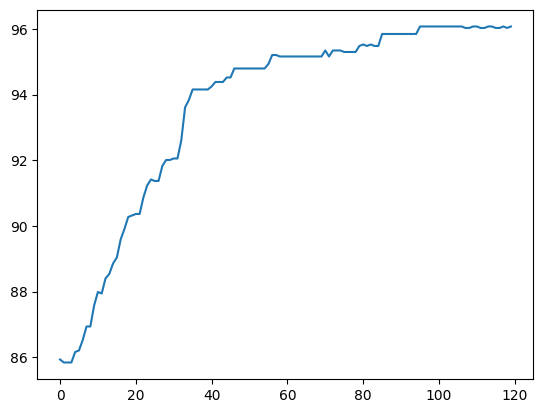

In [14]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = model.to(my_device)

epochs = 120
lr = 1e-3
dataset = 'SoyNet'
prefix = 'ResNet18-FT-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 748
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
0
Predicted: Disease | Corrected: Disease | Confidence: 97.72%


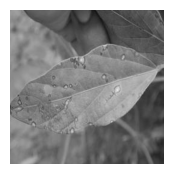

In [15]:
import numpy as np
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    my_transform = ResNet18_Weights.DEFAULT.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = ["Disease", "Healthy"]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
